# Tensorboard 활용



## `Scalar`, `Histogram`, `Distribution`

- Tensorboard `Scalars`, `Histogram`, `Distribution` 탭 사용
- 텐서보드를 위한 summary data 를 파일에 기록, 확인
- 텐서보드를 위한 histogram data 를 파일에 기록, 확인

## 주요 메소드/단계

- tf.summary.FileWriter(dir_path,graph)
- tf.summary.scalar(a_tensor)
- tf.summary.histogram(a_tensor)
- tf.summary.merge([summary_1,summary_2,...])
- tf.summary.merge_all()
- summary_op eval
- writer.add_summary()

### 수요일 실습의 mnist_linear.py 에서 발췌

In [1]:
from __future__ import print_function, division
import os
import numpy as np
import tensorflow as tf
from mnist_data import load_mnist, load_mnist_t10k
from image_util import save_image

## 1주차 수요일 MNIST 실습 데이터와 동일한 데이터 사용

In [2]:
data_dir = './mnist'
data_dir

'./mnist'

## 다운로드 - 쉘 스크립트 실행

In [3]:
%%bash
if test ! -s ./mnist/t10k-images-idx3-ubyte
then
    mkdir -p ./mnist
    cd ./mnist
    echo "$(pwd)"
    wget -q http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
    wget -q http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
    wget -q http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
    wget -q http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
    gzip -d *.gz
fi

### MNIST 데이터 특성 및, batch size, learning rate 설정

In [4]:
batch_size    = 128
learning_rate = 0.05

input_size    = 28 * 28
output_size   = 10

## MNIST 훈련용 그래프 구축

In [5]:
input_       = tf.placeholder(shape=[None, input_size],
                        dtype=tf.float32, name="input")
label_       = tf.placeholder(shape=[None],
                        dtype=tf.int64, name="label")

weights      = tf.Variable(tf.zeros([input_size, output_size]))
biases       = tf.Variable(tf.zeros([output_size]))
output       = tf.matmul(input_, weights) + biases
pred         = tf.nn.softmax(output)

label_onehot = tf.one_hot(label_, output_size, axis=1)
loss         = tf.reduce_mean(
                    tf.nn.softmax_cross_entropy_with_logits(
                        logits=output,
                        labels=label_onehot))
trainer      = tf.train.GradientDescentOptimizer(
                    learning_rate=learning_rate)
optimize     = trainer.minimize(loss)

correct      = tf.equal(tf.argmax(pred, axis=1), label_)
accuracy     = tf.reduce_mean(tf.cast(correct, tf.float32))

## summary_op 텐서를 그래프에 추가

- `summary_op` 도 또 다른 `tensor` 라는 점에 유의
- 따라서 `session.run()` 이나 `eval()` 없이 직접 사용할 수 없음

In [6]:
tf.summary.scalar('loss',loss)
tf.summary.scalar('accuracy',accuracy)
summary_op = tf.summary.merge_all()

## 그래프는 준비되었고, 이제 훈련/테스트를 위한 루프를 작성

### 데이터 로딩

In [7]:
images, labels       = load_mnist(data_dir)
t_images, t_labels   = load_mnist_t10k(data_dir)
images               = images / 127.0 - 1.0
t_images             = t_images / 127.0 - 1.0

### 세션 설정, 세션 생성, 초기화

In [8]:
# allow_growth 옵션을 사용하면, 텐서플로우가
# 시작할 때 무조건 GPU 메모리 전체를 할당해서
# 쓰지 않고 필요한 만큼만 할당 받아 사용하도록
# 할 수 있음
config    = tf.ConfigProto()
config.gpu_options.allow_growth = True

session   = tf.InteractiveSession(config=config)

init      = tf.global_variables_initializer()
session.run(init)

### 훈련용 배치 갯수, 테스트용 배치 갯수 계산

In [9]:
batch_count     = 60000 // batch_size
test_count      = 10000 // batch_size

### summary 를 logdir 디렉토리에 저장해 주는 FileWriter 생성

In [10]:
# 혹시 이전 실행에서 만든 결과가 파일로 저장되어 있으면 먼저 지우고 시작
!rm -fvr logdir

logdir/events.out.tfevents.1504687195.rhee-mbp.local
logdir


In [11]:
writer = tf.summary.FileWriter('logdir',graph=tf.get_default_graph())
writer

### summary 를 기록할 때 사용할 스텝 카운터 추가

In [12]:
step = 1

### 훈련을 위한 루프는 화요일 실습의 mnist_linear.py 에서 발췌

- line 9,10 과 23,24 에 추가된 writer 사용방법에 주목

In [13]:
for ep in range(50):
    total_loss = 0
    total_acc_v = 0
    for i in range(batch_count):
        img = np.reshape(
                images[i*batch_size:(i+1)*batch_size],
                [batch_size, 28 * 28])
        lbl = (labels[i*batch_size:(i+1)*batch_size])
        _, loss_v, acc_v, summary_v = session.run([
                                        optimize, loss, accuracy, summary_op], \
                                        feed_dict= {input_: img, label_: lbl})
        
        writer.add_summary(summary_v)   # <<<===== add_summary!
        step += 1
        
        total_loss += loss_v
        total_acc_v += acc_v

    total_acc = 0
    for a in range(test_count):
        index = a * batch_size
        img = np.reshape(
                t_images[index:index+batch_size], \
                [batch_size, 28 * 28])
        lbl = t_labels[index:index+batch_size]
        acc,summary_t = session.run(
                            [accuracy, summary_op], \
                            feed_dict={input_:img, label_:lbl})
        
        writer.add_summary(summary_v)   # <<<===== add_summary!
        step += 1

        total_acc += acc

    total_acc = total_acc / test_count

    print('epoch %d: loss: %.5f acc: %.5f test_acc: %.2f%%' % (
        ep+1, 
        total_loss / batch_count, 
        total_acc_v / batch_count, 
        total_acc * 100))

epoch 1: loss: 0.51362 acc: 0.85306 test_acc: 89.49%
epoch 2: loss: 0.34259 acc: 0.90014 test_acc: 90.27%
epoch 3: loss: 0.32064 acc: 0.90680 test_acc: 90.61%
epoch 4: loss: 0.30919 acc: 0.91017 test_acc: 90.84%
epoch 5: loss: 0.30176 acc: 0.91279 test_acc: 90.94%
epoch 6: loss: 0.29638 acc: 0.91485 test_acc: 90.95%
epoch 7: loss: 0.29221 acc: 0.91642 test_acc: 90.96%
epoch 8: loss: 0.28883 acc: 0.91779 test_acc: 91.08%
epoch 9: loss: 0.28601 acc: 0.91887 test_acc: 91.13%
epoch 10: loss: 0.28359 acc: 0.91989 test_acc: 91.18%
epoch 11: loss: 0.28148 acc: 0.92054 test_acc: 91.18%
epoch 12: loss: 0.27962 acc: 0.92111 test_acc: 91.25%
epoch 13: loss: 0.27795 acc: 0.92159 test_acc: 91.34%
epoch 14: loss: 0.27644 acc: 0.92211 test_acc: 91.35%
epoch 15: loss: 0.27507 acc: 0.92248 test_acc: 91.42%
epoch 16: loss: 0.27381 acc: 0.92286 test_acc: 91.44%
epoch 17: loss: 0.27265 acc: 0.92321 test_acc: 91.43%
epoch 18: loss: 0.27158 acc: 0.92351 test_acc: 91.43%
epoch 19: loss: 0.27058 acc: 0.92386 

### 텐서보드 실행

- `SCALARS` 탭에서 그래프 확인
- `Horizontal Axis` 의 선택을 `STEP`, `RELATIVE`, `WALL` 로 전환 해 봄
- `Smoothing` 슬라이더를 움직여 봄
- `Ignore outliers` 체크박스의 효과를 확인
- `Show data download links` 및, 다운로드된 csv 파일을 다른 프로그램으로 확인
- filter 기능 확인
- 텐서보드 감상 후 정지 버튼을 누르거나 `Kernel` `->` `Interrupt` 메뉴를 선택


In [14]:
!tensorboard --logdir logdir

Starting TensorBoard 54 at http://rhee-mbp.local:6006
(Press CTRL+C to quit)
^C


## 기대했던 그림이 나오지 않았을 것입니다

- add_summary() 호출시 global_step= 값을 적어 줘야 함

- 이번에는 [tqdm](https://pypi.python.org/pypi/tqdm) 을 써 봅시다 

In [15]:
# 먼저, 현재 env 에 tqdm 이 설치되어 있지 않으면 설치
# 쉘 명령어 pip 를 이용
!pip install tqdm

In [16]:
from tqdm import tqdm

In [17]:
for ep in tqdm(range(50)):
    total_loss = 0
    total_acc_v = 0
    for i in range(batch_count):
        img = np.reshape(images[i*batch_size:(i+1)*batch_size], \
                         [batch_size, 28 * 28])
        lbl = (labels[i*batch_size:(i+1)*batch_size])
        _, loss_v, acc_v, summary_v = session.run([ \
                                        optimize, loss, accuracy, summary_op], \
                                        feed_dict= {input_: img, label_: lbl})

        writer.add_summary(summary_v,step)
        step += 1
        
        total_loss += loss_v
        total_acc_v += acc_v

    total_acc = 0
    for a in range(test_count):
        index = a * batch_size
        img = np.reshape(t_images[index:index+batch_size], \
                         [batch_size, 28 * 28])
        lbl = t_labels[index:index+batch_size]
        acc,summary_t = session.run([accuracy, summary_op], \
                                    feed_dict={input_:img, label_:lbl})
        
        writer.add_summary(summary_v,step)
        step += 1

        total_acc += acc
    total_acc = total_acc / test_count

print('epoch %d: loss: %.5f acc: %.5f test_acc: %.2f%%' % (
    ep+1, 
    total_loss / batch_count, 
    total_acc_v / batch_count, 
    total_acc * 100))

100%|██████████| 50/50 [00:25<00:00,  1.96it/s]

epoch 50: loss: 0.24566 acc: 0.93187 test_acc: 91.76%


In [18]:
!tensorboard --logdir logdir

Starting TensorBoard 54 at http://rhee-mbp.local:6006
(Press CTRL+C to quit)
^C


## logdir 에 뭐가 들어있는지 잠깐확인

In [19]:
!ls -la logdir

total 6368
drwxr-xr-x   3 rhee  staff      102 Sep  6 18:05 .
drwxrwxr-x  37 rhee  staff     1258 Sep  6 18:08 ..
-rw-r--r--   1 rhee  staff  3248369 Sep  6 18:06 events.out.tfevents.1504688727.rhee-mbp.local


## Histogram 기능 활용

- 특정 데이터의 히스토그램을 만들어 볼 수 있는 기능

- 활용 예:
    - 훈련용 데이터에 편향성이 있는지 테스트

    - `label_` placeholder 에 들어왔던 값들의 histogram 시각화

        `label_ = tf.placeholder(shape=[None], dtype=tf.int64, name="label")`


In [20]:
# logdir2 에 저장하기로
!rm -fr logdir2

In [21]:
# writer 는 새로운 logdir2 에 대해서 새로 만들어 사용
writer = tf.summary.FileWriter('logdir2',graph=tf.get_default_graph())

### 먼저, 그래프에 histogram summary 를 추가

In [22]:
hist_labels    = tf.summary.histogram('labels',tf.cast(label_,tf.float32))
hist_outputs   = tf.summary.histogram('outputs',tf.argmax(output,axis=1))

# summary_op 를 재정의. tf.summary.merge() 를 이용
summary_op = tf.summary.merge([hist_labels, hist_outputs])

### 나머지는 이전과 동일

In [23]:
# 이건 텐서보드 히스토그램을 위한 변수가 아님. 용도는 끝에서 설명
label_stats = [0] * 10

In [24]:
for ep in tqdm(range(50)):
    total_loss = 0
    total_acc_v = 0
    for i in range(batch_count):
        img = np.reshape(images[i*batch_size:(i+1)*batch_size],
                         [batch_size, 28 * 28])
        lbl = (labels[i*batch_size:(i+1)*batch_size])
        
        for l in lbl: 
            label_stats[l] += 1
            
        _, loss_v, acc_v, summary_v = session.run(
                                        [optimize, loss, accuracy, summary_op],
                                        feed_dict= {input_: img, label_: lbl})
        
        writer.add_summary(summary_v,step)
        step += 1

        total_loss += loss_v
        total_acc_v += acc_v

    total_acc = 0
    for a in range(test_count):
        index = a * batch_size
        img = np.reshape(t_images[index:index+batch_size],
                         [batch_size, 28 * 28])
        lbl = t_labels[index:index+batch_size]
        
        for l in lbl:
            label_stats[l] += 1

        acc,summary_t = session.run([accuracy, summary_op],
                                    feed_dict={input_:img, label_:lbl})
        
        writer.add_summary(summary_v,step)
        step += 1
        
        total_acc += acc
    total_acc = total_acc / test_count
    
print('epoch %d: loss: %.5f acc: %.5f test_acc: %.2f%%' % (
    ep+1, 
    total_loss / batch_count, 
    total_acc_v / batch_count, 
    total_acc * 100))

100%|██████████| 50/50 [00:37<00:00,  1.33it/s]

epoch 50: loss: 0.24095 acc: 0.93339 test_acc: 91.78%


In [25]:
!tensorboard --logdir logdir2

Starting TensorBoard 54 at http://rhee-mbp.local:6006
(Press CTRL+C to quit)
^C


### 그림이 좀 이상할 수 있음, 다른 방법으로 다시 확인

- 위에 이렇게 적은 부분이 있습니다

        # 이건 텐서보드 히스토그램을 위한 변수가 아님. 용도는 끝에서 설명
        label_stats = [0] * 10

- 학습 및 테스트 루프의 중간에 이런 코드도 있습니다

        for l in lbl:
            label_stats[l] += 1

- 이렇게 파이썬 코드로 수집한 히스토그램 데이터를 그래프로 그려 봅니다

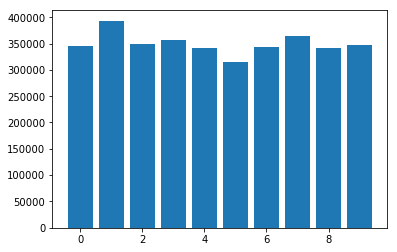

In [26]:
# pyplot 로 그린 그래프가 jupyter notebook 셀 내부에
# 그려지게 하려면 %matplotlib inline 이라고 적어줍니다.
# (이건 jupyter notebook 에서만 가능함. 파이썬에서 지원하는 것이 아님)
%matplotlib inline
import matplotlib.pyplot as plt
plt.bar(range(len(label_stats)),label_stats);

### 텐서보드는 다양한 범위의 데이터에 대한 히스토그램을 보여주기 위해서 몇 가지 트릭을 사용함

- [exponentially distributed bins](https://www.tensorflow.org/get_started/tensorboard_histograms)

    - 0 에 가까울 수록 많은 갯수의 bin 할당 ( 보다 정확하게 구분되어 보임 )
    
    - 값이 클수록 적은 갯수의 bin 할당, 따라서 많은 값들이 동일한 bins 에 포함되어 값이 뭉쳐져서 보임
    
    - 실제로 입력한 값들이 정수라고 해도, 히스토그램 상에서는 bin 중심과 bin 너비가 실수로 표현되고, 카운터도 실수로 표현됨


- [reservoir sampling](https://en.wikipedia.org/wiki/Reservoir_sampling)

    - "Reservoir sampling is a family of randomized algorithms for randomly choosing a sample of k items from a list S containing n items, where n is either a very large or unknown number. Typically n is large enough that the list doesn't fit into main memory."
